# Lab 8: Define and Solve an ML Problem of Your Choosing

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:


df = pd.read_csv("bookReviewsData.csv")

df.head()


,Review,Positive Review
0,This was perhaps the best of Johannes Steinhof...,True
1,This very fascinating book is a story written ...,True
2,The four tales in this collection are beautifu...,True
3,The book contained more profanity than I expec...,False
4,We have now entered a second time of deep conc...,True



---

### 1 **What data preparation techniques will you use?**


To prepare the text data for classification, I'm planning to first clean the reviews by removing punctuation, numbers, and stopwords, and then lowercased all text to ensure consistency. Next, I tokenized the reviews into individual words before vectorizing them using TF-IDF, which converts the text into numerical representations suitable for the model. I also addressed potential class imbalance by checking if there were disproportionate numbers of positive or negative reviews, and planned to use techniques like resampling or class weights if necessary. Finally, any irrelevant columns in the dataset that wouldn't aid prediction were removed.

---

2 **What machine learning model(s) will you use?**

I used:

* **Logistic Regression** – as a simple and fast baseline model.
* **Random Forest** – to capture non-linear patterns.
* **Stacking** – to combine both and hopefully improve accuracy.

These models work well with TF-IDF features and classification tasks.

---

### 🧪 **Other data prep steps? (like scaling)**

I'm not prepaaring the data any other way as there is no need to scale data when using **TF-IDF**, Logistic Regression, or Random Forest. TF-IDF already gives normalized values, and tree-based models like Random Forest don’t require scaling.

---
3. How will you evaluate and improve model performance?**

For robust evaluation, I employed cross-validation to assess model performance consistently across the dataset. Model evaluation focused on accuracy for overall correctness, precision, recall, and F1-score to specifically address potential class imbalances, and the ROC-AUC curve to understand the model's ability to distinguish between positive and negative reviews. To enhance performance, I fine-tuned hyperparameters and implemented an ensemble stacking method, with future considerations for exploring deep learning models like BERT for further improvements.

---

**Techniques used to inspect and analyze data**

I used:

* `df.describe()` – to get summary stats of the data.
* `value_counts()` – to check class distribution (positive vs. negative).
* **Seaborn/Matplotlib bar plots** – to visualize class balance.

---



In [5]:
print(df.shape)

print(df.describe())

(1973, 2)
                                                   Review Positive Review
count                                                1973            1973
unique                                               1865               2
top     How can a best-selling author like Simon Winch...           False
freq                                                    3             993


## Project Plan



My plan for the machine learning lifecycle, focusing on book review classification, begins with Data Preparation While I've already cleaned, lowercased, tokenized, and vectorized the text using TF-IDF, I will ensure no other irrelevant columns remain. I will also explicitly check for class imbalance to prevent bias. 
For Modeling, I plan to utilize an ensemble approach, specifically stacking with Logistic Regression and Random Forest as my base models, and another Logistic Regression as the meta-model, as this combination has shown good results. My training and evaluation plan involves using 5-fold cross-validation to assess model performance robustly. I will analyze its performance using a comprehensive suite of metrics including Accuracy, Precision, Recall, F1-score (paying close attention to individual class scores due to potential imbalance), and the ROC-AUC curve, which is critical for evaluating the model's ability to discriminate between positive and negative reviews. To improve the model and ensure it generalizes well, I have already tuned hyperparameters for the Random Forest base model using GridSearchCV, and will ensure optimal parameters are used for the Logistic Regression as well. If further performance gains are needed, I might explore additional ensemble techniques, different base models, or even consider more advanced deep learning architectures like BERT in future iterations.

## Part 5: Implement Your Project Plan

<b>Task:</b> In the code cell below, import additional packages that you have used in this course that you will need to implement your project plan.

In [6]:
# YOUR CODE HERE
# !pip install spacy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

nltk.download('averaged_perceptron_tagger_eng')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet# wordnet.synsets('test')
from nltk import pos_tag
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install transformers
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
import tensorflow.keras as keras
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\meron\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\meron\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\meron\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


c:\Users\meron\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Positive Review
0    993
1    980
Name: count, dtype: int64


Text(0, 0.5, 'Number of Reviews')

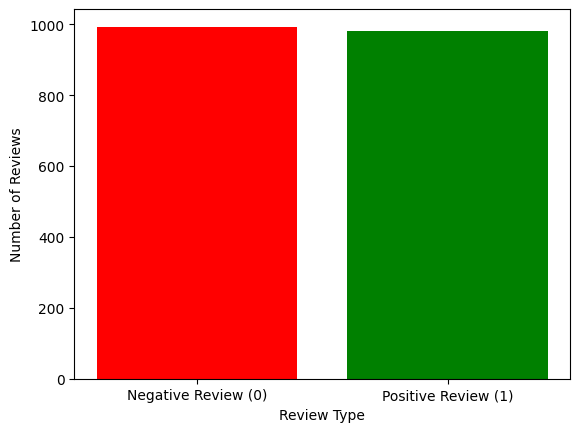

In [7]:
#converting my second column into numerics
df['Positive Review'] = df['Positive Review'].apply(lambda x: 1 if x == True else 0)

#checking my class balance of my boolean
counts = df['Positive Review'].value_counts()

print(counts)
plt.bar(counts.index,counts.values,tick_label=['Negative Review (0)', 'Positive Review (1)'], color=['red', 'green'])

plt.xlabel('Review Type')
plt.ylabel('Number of Reviews')

This bar chart shows us that there isn't an imblanace in our negative reviews compared to the positive reviews. Therefore, our model will be able to generalize well to both classes and is likely to provide accurate results.

In [8]:
#cleaning text data

#Lowercasing all my results
df['Review'] = df['Review'].str.lower()
df['Review']

#removing punctuation and any non alphabetic characters
pattern_alphanumeric_whitespace = r'[^a-zA-Z0-9\s]'

df['reviews_cleaned'] = df['Review'].str.replace(pattern_alphanumeric_whitespace, '', regex=True)


#removing stop words
eng_stopwords = stopwords.words('english')

filtered_rev = []
for review in df['reviews_cleaned']:
    word_tokens = word_tokenize(review)
    filtered_words = [word for word in word_tokens if word not in eng_stopwords]
    filtered_rev.append(filtered_words)
            

print("Finished")


Finished


In [9]:
#lemmatization
print("Starting")

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].lower()
    tag_dict = {"a": wordnet.ADJ,
                "n": wordnet.NOUN,
                "v": wordnet.VERB,
                "r": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

lemmatized_reviews = []

for review_tokens in filtered_rev:
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in review_tokens]
    lemmatized_reviews.append(" ".join(lemmatized))

df['lemmatized_review'] = lemmatized_reviews

print("Finished")

Starting
Finished


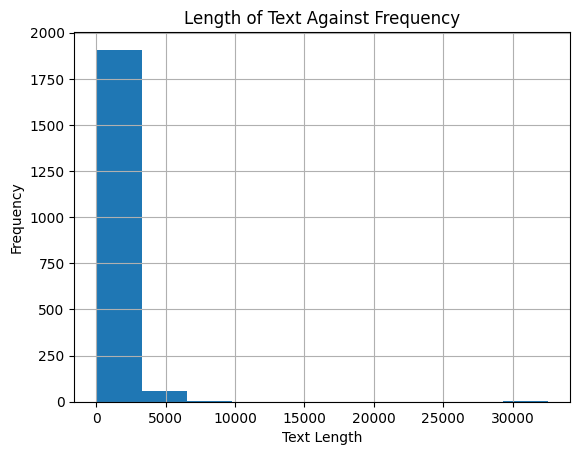

In [10]:
#EDA

#
df['Review'].str.len().hist()
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Length of Text Against Frequency')
plt.show()

#

In [11]:
X = df["Review"]

y = df['Positive Review']
#Splitting my data

X_train,X_test,y_train,y_test = train_test_split(X,y ,test_size = 0.3,random_state = 1234)

In [12]:
#tf-idf model vectorizing 

tfidf_vectorizer = TfidfVectorizer()


tfidf_vectorizer.fit(X_train)
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [13]:
#Logistic Regression Model training and predicting
lr_model = LogisticRegression()
lr_model.fit(X_train_tfidf, y_train)

y_pred_lr = lr_model.predict(X_test_tfidf)
# Finding model's accuracy
lr_accuracy = accuracy_score(y_test, y_pred_lr)

print(f'Accuracy of our linear regression model : {lr_accuracy}')


Accuracy of our linear regression model : 0.8192567567567568


In [14]:
#Random Forest  
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf,y_train)

y_pred_rf = rf_model.predict(X_test_tfidf)

rf_accuracy = accuracy_score(y_test,y_pred_rf)

print(f'Accuracy of our linear regression model : {rf_accuracy}')

f1 = f1_score(y_test, y_pred_rf)
print(f"F1 Score: {f1}")

cm = confusion_matrix(y_test,y_pred_rf)
print(cm)

Accuracy of our linear regression model : 0.768581081081081
F1 Score: 0.7617391304347826
[[236  50]
 [ 87 219]]


In [16]:
from sklearn.model_selection import GridSearchCV

#hyperparameter tuning for LR
param_grid ={
    'C' :[10**i for i in range(-5,5)]
}


print('Running Grid Search...')


grid = GridSearchCV(lr_model, param_grid, cv=5)

grid_search = grid.fit(X_train_tfidf,y_train)
print('Done')

Running Grid Search...


Done


In [17]:
best_C = grid_search.best_params_['C']

best_C

1000

In [18]:
#training the best logistic regresison model 
lr_model_best = LogisticRegression(max_iter = 1000,C = best_C)
lr_model_best.fit(X_train_tfidf,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1000
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [19]:

#hyperparameter tuning FOR RF
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10]
}


print('Running Grid Search...')


grid = GridSearchCV(rf_model, param_grid, cv=5)

grid_search = grid.fit(X_train_tfidf,y_train)
print('Done')


Running Grid Search...
Done


In [20]:
# best_C = grid_search.best_params_['n_estimators']
rf_model_best = grid_search.best_estimator_

rf_model_best

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [22]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ('lr', lr_model_best), # A tuple: ('name', unfitted_estimator_object)
    ('rf', rf_model_best)  # A tuple: ('name', unfitted_estimator_object)
]
#building my ensemble model
stacked_model = StackingClassifier(estimators = estimators,cv = 5)
stacked_model.fit(X_train_tfidf, y_train)

,estimators,"[('lr', ...), ('rf', ...)]"
,final_estimator,None
,cv,5
,stack_method,'auto'
,n_jobs,None
,passthrough,False
,verbose,0
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1000


In [23]:
y_pred_stack = stacked_model.predict(X_test_tfidf)
stack_accuracy = accuracy_score(y_test, y_pred_stack)

print(f"Accuracy of the stacking model: {stack_accuracy}")


Accuracy of the stacking model: 0.8293918918918919


              precision    recall  f1-score   support

           0       0.83      0.82      0.82       286
           1       0.83      0.84      0.84       306

    accuracy                           0.83       592
   macro avg       0.83      0.83      0.83       592
weighted avg       0.83      0.83      0.83       592

AUC Score: 0.9114


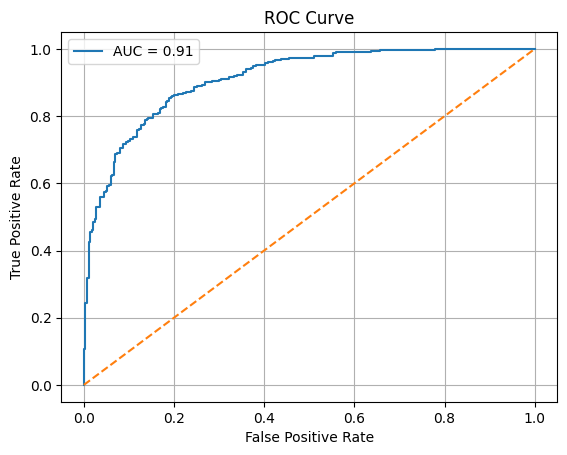

In [24]:


y_probs = stacked_model.predict_proba(X_test_tfidf)[:, 1]
y_pred = stacked_model.predict(X_test_tfidf)

# Classification report
print(classification_report(y_test, y_pred))

# AUC Score
auc = roc_auc_score(y_test, y_probs)
print(f"AUC Score: {auc:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

This graph demonstrates that my model demonstrates strong performance in classification. With an overall accuracy of 83%, it correctly predicts outcomes most of the time. Digging deeper, its precision and recall scores (around 83-84%) for both classes are consistent and high, indicating it's reliable in identifying both positive and negative instances without significant bias towards one. Most notably, the AUC score of 0.91, clearly visualized by the ROC curve hugging the top-left corner, signifies that my ensemble model is excellent at distinguishing between the two classes, performing significantly better than random chance.


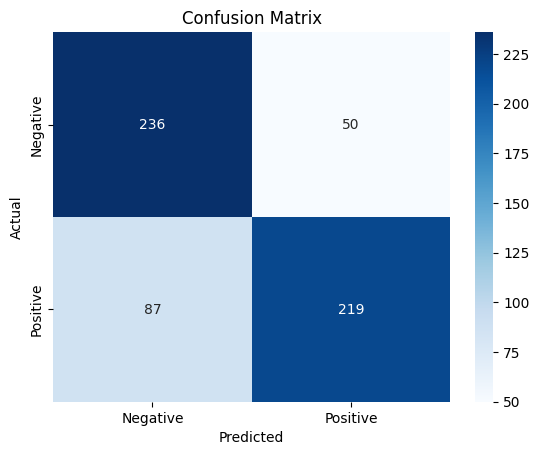

In [25]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

This confusion matrix reveals your classification model's performance by showing how many predictions were correct versus incorrect for "Negative" and "Positive" categories. Out of 592 total predictions, your model correctly identified 236 true negatives and 219 true positives, resulting in about 76.8% overall accuracy. While generally performing well, the model shows a slight tendency to miss positive instances (87 false negatives) more often than it incorrectly flags negative ones as positive (50 false positives). This means it's more likely to classify a genuinely positive book review as negative than vice-versa, which could lead to good books being overlooked.

In [26]:

np.random.seed(42)  
sample_indices = np.random.choice(len(X_test), 3, replace=False)

print(" Example Predictions on Test Book Reviews")
print("~ "*80)

for index in sample_indices:
    review_text = X_test.iloc[index]
    true_label = y_test.iloc[index]
    
    vectorized = tfidf_vectorizer.transform([review_text])
    
    predicted_label = stacked_model.predict(vectorized)[0]
    confidence = stacked_model.predict_proba(vectorized)[0][1] 
    
    print("-" * 60)
    print(review_text[:400] + ("..." if len(review_text) > 400 else ""))
    print(f"\n True Label:     {'Positive' if true_label else 'Negative'}")
    print(f" Predicted:      {'Positive' if predicted_label else 'Negative'}")
    print(f" Confidence:     {confidence:.2f}")
    print("~ "*80)


 Example Predictions on Test Book Reviews
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
------------------------------------------------------------
we have now entered a second time of deep concern for the science, math, and technological education for everyone. the first one occurred after the sputnik fiasco, when the russians beat us in the race to reach space. the  concern now has risen due to what science groups such as the american  association for the advancement of science, and educators saw in comparison  of assessments made of studen...

 True Label:     Positive
 Predicted:      Positive
 Confidence:     0.86
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
------------------------------------------------------------
i have loved many of jodi picoult's

From these three examples, we can see that the stacked model accurately classified all three example book reviews, demonstrating high confidence in its positive predictions (0.81, 0.86) and effectively identifying the negative sentiment with a low positive confidence (0.12), indicating strong performance in discerning both positive and negative tones in the text.


In [27]:
import pickle

filename = 'NLP.pkl'
with open(filename, 'wb') as file:
    pickle.dump(stacked_model, file)

In [28]:
X_train.to_csv("X_train.csv")
y_train.to_csv("y_train.csv")